# Transformer Preliminaries 


## Framing
> GOAL: Create a notebook with proof-of-concepts/examples for each component of the upcoming transformer/Perceiver architecture. 

Objectives: 
 1. Gain familiarity with the code side of transformers.
 2. Create examples of each unfamiliar components of the project. 
 3. Maximize copy-paste-ability. 


## Diverging 
> Things to prototype.

 - [ ] Patch extraction.
	 - [ ] Video.
	 - [ ] Audio. 
	 - [ ] VTT subtitle files. 
 - [ ] Text tokenization/vectorization. 
 - [ ] Implementation of spacetime Fourier features (positional encoding).
 - [ ] Attention blocks (self attention, cross attention).
	 - Should be a `dmodel` or whatever Tensorflow uses. 
 - [ ] Masking for transformer layers. 
 - [ ] Decoder/encoder cold start (cf. Perceiver paper).
 - [ ] How to query latent space for specific spatiotemporal coordinates?
 - [ ] Figure out how to use GPU on Thomson Lab HPC. 

In [60]:
## Import box 
import os 
import sys 
import random
import pathlib
import itertools
import collections
import math

import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
import pathlib 
from tqdm.notebook import tqdm
import cv2
# Some modules to display an animation using imageio.
import imageio
from IPython import display
from urllib import request
from tensorflow_docs.vis import embed

In [3]:
## Meta/constants 
DATA_FOLDER = "../datasets/downloads"
num_videos, num_frames = 10, 101
output_size = (240, 360)

## 1: Acquire Dataset

In [4]:
sys.path.append("../src")
import video_loader as vl

In [5]:
VideoSet = vl.get_videoset("../datasets/downloads", num_videos, num_frames, output_size=output_size)

  0%|          | 0/10 [00:00<?, ?it/s]2022-10-03 15:01:17.894969: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/aman/.local/lib/python3.9/site-packages/cv2/../../lib64:
2022-10-03 15:01:17.894994: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-10-03 15:01:17.895350: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI

In [6]:
print(VideoSet)

<BatchDataset element_spec=TensorSpec(shape=(None, 101, 240, 360, 3), dtype=tf.float32, name=None)>


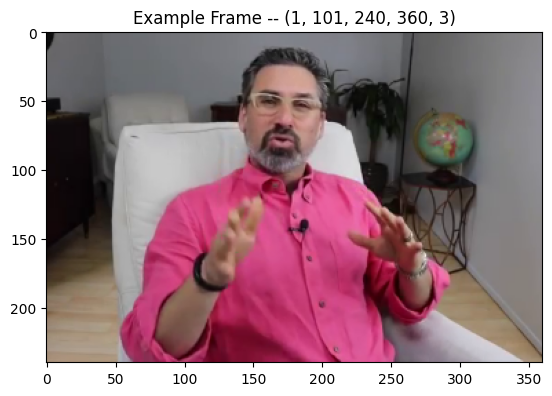

In [14]:
for element in VideoSet:
	plt.imshow(element[0,50,:,:,:])
	plt.title(f"Example Frame -- {element.shape}")
	break

## 2: Make Spacetime Patches (Video)

> Goal: Create array of patches, reshape back into regular video tensor.

 - `PatchedSet`: [batch, num_time_slices, num_height_slices, num_width_slices, num_RGBVals_per_patch]. 
 - `FlatPatchedSet`: 

In [52]:
patch_height = 16
patch_width = 16
patch_duration = 3

ksizes=[1,patch_duration,patch_height,patch_width,1] # 4 duration, 16x16 height-width 

def create_patches(video_tensor, ksizes=[1,4,16,16,1]): 
	"""Converts `video_tensor` into a sequence of patches.
	Input has shape [frames, width, height, channels]

	ksizes=[1,4,16,16,1] -> 4 temporal depth, 16 height/width. 
	"""
	return tf.extract_volume_patches(video_tensor, ksizes,ksizes,"VALID")

PatchedSet = VideoSet.map(lambda x: create_patches(x, ksizes=ksizes))

In [53]:
## PatchedSet now has all the patches, but they aren't fully flattened -- 
# There's a 3072-long vector at every point where there would have been a patch.
# Still gotta add positional encoding and fully flatten out into a 2D matrix. 
PatchedSet # [batchsize, realduration/timepatch, height/heightpatch, width/widthpath, all RGB datum]
		   # RGB data: All RGB values for a patch of size (timedur * heightpatch * widthpatch) * 3 channels.

<MapDataset element_spec=TensorSpec(shape=(None, 33, 15, 22, 2304), dtype=tf.float32, name=None)>

Element shape:  (1, 33, 15, 22, 2304)
First patch shape:  (2304,)
Element shape:  (1, 33, 15, 22, 2304)
First patch shape:  (2304,)
Element shape:  (1, 33, 15, 22, 2304)
First patch shape:  (2304,)
Element shape:  (1, 33, 15, 22, 2304)
First patch shape:  (2304,)
Element shape:  (1, 33, 15, 22, 2304)
First patch shape:  (2304,)
Element shape:  (1, 33, 15, 22, 2304)
First patch shape:  (2304,)
Element shape:  (1, 33, 15, 22, 2304)
First patch shape:  (2304,)
Element shape:  (1, 33, 15, 22, 2304)
First patch shape:  (2304,)
Element shape:  (1, 33, 15, 22, 2304)
First patch shape:  (2304,)
Element shape:  (1, 33, 15, 22, 2304)
First patch shape:  (2304,)


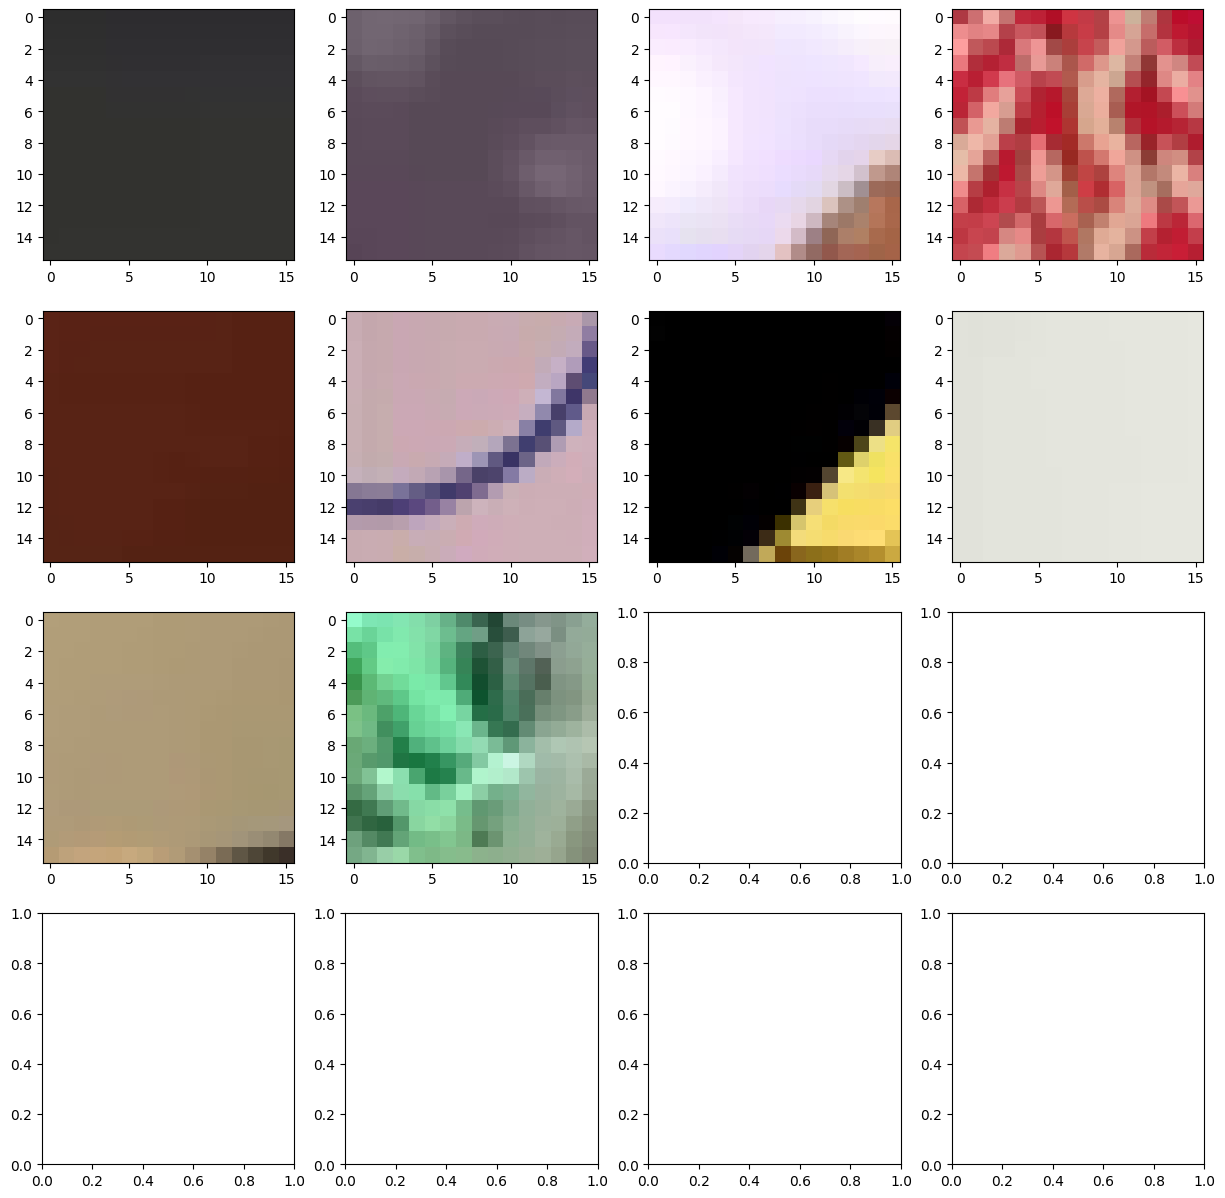

In [66]:
## Let's decode a single spacetime patch

nplots = math.ceil(math.sqrt(len(PatchedSet)))
fig, axs = plt.subplots(nplots, nplots)
fig.set_figheight(15)
fig.set_figwidth(15)

cnt=0
for element in PatchedSet: 
	
	# plt.imshow()tf.reshape(element[0,0,:,:,0]), (16,16,3)
	# print("Element shape: ", element.shape)
	first_patch = element[0,3,3,4,:]
	# print("First patch shape: ", first_patch.shape)
	first_patch = tf.reshape(first_patch, [patch_duration, patch_height, patch_width, 3] ) # time, height, width, channels 
	axs[cnt//nplots, cnt%nplots].imshow(first_patch[2,:,:,:])
	cnt+=1
plt.show()

In [54]:
def unpatch(patch_tensor, ksizes):
	"""Converts a patchified tensor with shape 
		[batch, n_timepatch, n_heightpatch, n_widthpatch, RGBTotal] 
	where RGBTotal = (n_timepatch * n_heightpatch * n_widthpatch) * channels 
	and channels = 3 RGB channels.

	Into a video tensor of shape [batch, nframes, height, width, channels]

	ksizes = [1, patch_time, patch_height, patch_width, 1]
	"""
	... # TODO


In [55]:
def flatten_patched(patch_tensor):
	""" Flattens the 3D structure of spacetime patches into a [batch, num_patches, patch_len] 
	tensor. Should be applied after positional encoding, generally. 
	"""
	b, t, h, w, cs = patch_tensor.shape
	return tf.reshape(patch_tensor, b, t*h*w, cs)